In [204]:
import geopandas as gpd
import pandas as pd
import numpy as np
import leafmap
import leafmap
import geemap
import ee
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [205]:
filepath = 'D:\Trainings\gee\Pabbi_RevisedLandtype-V4.geojson'
gdf=gpd.read_file(filepath)
gdf.head()

,Area_Acre,Crop_Type,FFID,Landuse_Ma,Mouza_Name,Parcel_ID,agri_count,built_count,NDVI,NDBI,...,NDWI,B2,B3,B4,B8,B11,pct_built,pct_agri,landuse_class,geometry
0,0.101785,None,1,Agriculture,Khushmaqam,668,90.725490,181.058824,0.226656,-0.016614,...,-0.261929,1080.794583,1314.424346,1412.001354,2250.015724,2147.930654,0.666186,0.333814,Partial-Builtup,"POLYGON ((71.74996 34.03193, 71.75027 34.03195..."
1,0.315557,None,3,Agriculture,Khushmaqam,632,445.384314,928.509804,0.254974,0.013744,...,-0.298905,905.980655,1133.265953,1248.493593,2115.168267,2148.237869,0.675823,0.324177,Partial-Builtup,"POLYGON ((71.74868 34.03205, 71.74869 34.03195..."
2,0.187644,None,4,Agriculture,Khushmaqam,669,241.717647,430.784314,0.248897,-0.003842,...,-0.284861,989.403836,1234.108843,1331.561342,2231.942662,2198.647527,0.640570,0.359430,Partial-Builtup,"POLYGON ((71.75021 34.03218, 71.75022 34.0321,..."
3,0.161568,None,5,Agriculture,Khushmaqam,693,955.690196,434.231373,0.410130,-0.109844,...,-0.431634,806.999988,1099.118312,1177.751882,2761.666157,2193.297278,0.312414,0.687586,Pure-Agriculture,"POLYGON ((71.75401 34.03224, 71.75403 34.03219..."
4,0.229336,None,6,Agriculture,Khushmaqam,667,170.831373,437.709804,0.197473,-0.011919,...,-0.233127,1160.127481,1376.297936,1480.144814,2196.267099,2126.134001,0.719277,0.280723,Partial-Builtup,"POLYGON ((71.74971 34.03192, 71.74996 34.03193..."


In [206]:
# Lets Convert the gdf of the original file to ee features utilizing earth engine power
ee.Authenticate()
ee.Initialize()
boundary = geemap.gdf_to_ee(gdf)

In [207]:
len(gdf)

5759

In [208]:
# Dropping the unnecessary columns
gdf.drop(columns =['agri_count','built_count','pct_built','pct_agri'], inplace=True)
gdf.columns

Index(['Area_Acre', 'Crop_Type', 'FFID', 'Landuse_Ma', 'Mouza_Name',
       'Parcel_ID', 'NDVI', 'NDBI', 'BUI', 'UI', 'NDWI', 'B2', 'B3', 'B4',
       'B8', 'B11', 'landuse_class', 'geometry'],
      dtype='object')

In [209]:
# Dropping the geometry column
gdf.drop(columns =['geometry'], inplace=True)
gdf.columns

Index(['Area_Acre', 'Crop_Type', 'FFID', 'Landuse_Ma', 'Mouza_Name',
       'Parcel_ID', 'NDVI', 'NDBI', 'BUI', 'UI', 'NDWI', 'B2', 'B3', 'B4',
       'B8', 'B11', 'landuse_class'],
      dtype='object')

In [11]:
# Checking for Null values.
#print("Null values in the dataset: ", gdf.isnull().sum())
#gdf.dropna(inplace=True)


In [210]:
print(len(gdf))
print(gdf['landuse_class'].value_counts())

5759
landuse_class
Pure-Agriculture       4482
Pure-Builtup            778
Partial-Builtup         426
Partial-Agriculture      73
Name: count, dtype: int64


In [211]:
# Lets Encode teh target labels into numbers
labels_encoder = LabelEncoder()
gdf['landuse_class_encoded'] = labels_encoder.fit_transform(gdf['landuse_class'])

gdf['landuse_class_encoded'].value_counts()

landuse_class_encoded
2    4482
3     778
1     426
0      73
Name: count, dtype: int64

In [213]:
# Lets seperte the featues and target

X = gdf[['B2','B3','B4','B8','B11', 'NDVI','NDBI', 'BUI', 'UI', 'NDWI']]
y = gdf['landuse_class_encoded']

#save class labels for later decoding
class_names = labels_encoder.classes_

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#initialize and train the model
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced' ,max_depth=15, min_samples_split=2, 
                                  random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15, random_state=42)

In [215]:
#Make the predictions
y_pred = rf_model.predict(X_test)


In [216]:
# Evaluate the Performance of the model

print("Classification Report:\n", classification_report(y_test, y_pred, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
                      precision    recall  f1-score   support

Partial-Agriculture       0.55      0.27      0.36        22
    Partial-Builtup       0.81      0.91      0.86       128
   Pure-Agriculture       1.00      1.00      1.00      1345
       Pure-Builtup       0.97      0.95      0.96       233

           accuracy                           0.98      1728
          macro avg       0.83      0.78      0.79      1728
       weighted avg       0.98      0.98      0.98      1728

Confusion Matrix:
 [[   6   16    0    0]
 [   4  116    0    8]
 [   0    0 1345    0]
 [   1   11    0  221]]


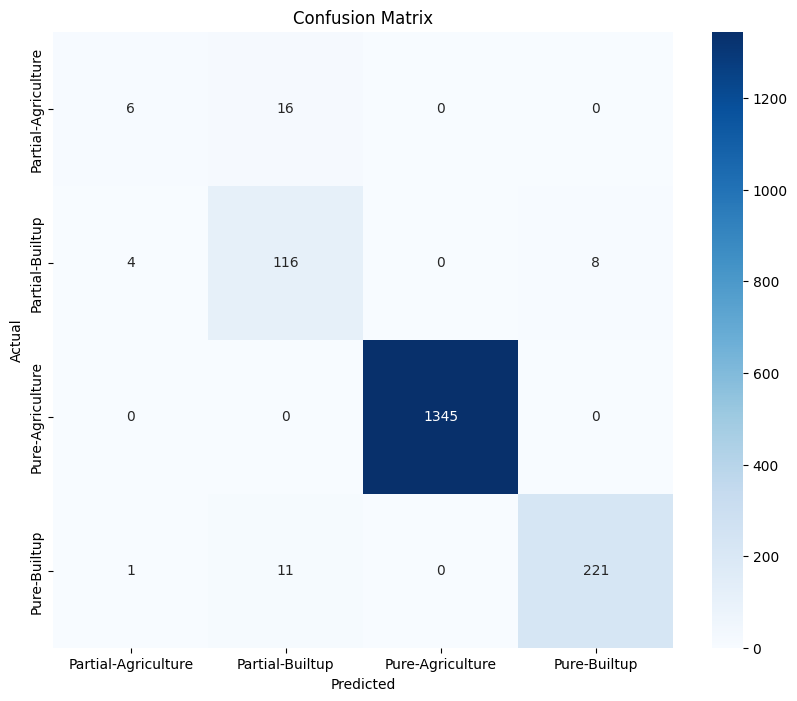

In [217]:
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [218]:
# Lets save the model for future use
import joblib
joblib.dump(rf_model, 'Landcover_randomforest_model.pkl')   


['Landcover_randomforest_model.pkl']

# Now we will be using this model for prediction on the whole dataset

# Predict Per Pixel (raster-based classification) 
## Steps
1. Prepare dataset
2. Generate a feature Stack Raster
3. Train the Random Forest
4. Apply the Model to the Entire Raster
5. Visualize and Validate

In [ ]:
#1 Prepare the dataset 
# Make sure that the dataset has requisite bands information.

In [219]:
# Define a function to get imagery an apply filter
def get_collection (start_date,end_date):
    collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    filtered_collection = collection.filterDate(start_date, end_date).filterBounds(boundary.geometry()).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
    return filtered_collection

In [220]:
# defing ndvi , NDBI , BUI and UI indices
def get_indices(image):
    ndwi = image.normalizedDifference(['B8', 'B11']).rename('NDWI')
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    ndbi = image.normalizedDifference(['B11', 'B8']).rename('NDBI')
    bui = (
        image.select('B11').add(image.select('B4'))
        .subtract(image.select('B8'))
        .subtract(image.select('B2'))
        .divide(
            image.select('B11')
            .add(image.select('B4'))
            .add(image.select('B8'))
            .add(image.select('B2'))
        )
        .rename('BUI')
    )
    ui = image.expression(
        '(NDVI - NDBI) / (NDVI + NDBI)', {
            'NDBI': ndbi,
            'NDVI': ndvi
        }).rename('UI')
    
  
    return image.addBands(ndvi).addBands(ndbi).addBands(bui).addBands(ui).addBands(ndwi)


In [221]:
def get_composite(filtered_collection):

    # Selecting requisite bands
    selected_bands = ['B2', 'B3', 'B4', 'B8', 'B11']
    filtered_collection = filtered_collection.select(selected_bands)
    # Add the indices to the image collection   
    # Add all indices to each image in the colleciton
    indexed_collection = filtered_collection.map(get_indices)   

    #Reduce the entire colleciton to a mean composite image
    composite_img = indexed_collection.mean()

    #These three lines are used to create a mask for the compoisite image to cover the holes in the image.
    #bandnames = composite_img.bandNames()
    #masks = bandnames.map(lambda b : composite_img.select([b]).mask())
    #validmasks_any = ee.ImageCollection(masks).reduce(ee.Reducer.max())

    #Clip to the boundary of pabbi
    composite_img = composite_img.clip(boundary.geometry())


    return composite_img


In [222]:
filtered_collection = get_collection('2022-01-01', '2024-12-31')
composite_img = get_composite(filtered_collection)

In [138]:
Map = geemap.Map(center=(37.5,70), zoom=10)

# To confirm that the composite Image is cropped 
vis_tc = {
    'bands': ['B4','B3','B2'],  # Red, Green, Blue
    'min': 0, 'max': 3000,      # Sentinel-2 SR values ~0–3000
    'gamma': 1.2
}
Map.addLayer(composite_img, vis_tc, 'True Color Composite', True)

Map.center_object(boundary, 10)
Map


Map(center=[34.02583430296346, 71.77387437607179], controls=(WidgetControl(options=['position', 'transparent_b…

In [223]:


# 1. Define output filename
out_tif = 'sentinel2_features_indices-V3.tif'

# 2. Export
geemap.ee_export_image(
    composite_img,
    filename=out_tif,
    scale=10,                                   # Sentinel-2 resolution
    region=boundary.geometry().bounds(),                 # your AOI
    file_per_band=False,                        # one multiband file
    crs='EPSG:4326' ,                            # or your preferred CRS
    
)

print(f"Exported multiband GeoTIFF: {out_tif}")


Generating URL ...
Please wait ...
An error occurred while downloading.
Exported multiband GeoTIFF: sentinel2_features_indices-V3.tif


In [224]:
import rasterio
import numpy as np
import joblib


In [225]:
# 1. Load your trained RF pipeline
rf_model = joblib.load('D:\Trainings\gee\Landcover_randomforest_model.pkl')

feature_cols = ['B2','B3','B4','B8','B11', 'NDVI','NDBI', 'BUI', 'UI', 'NDWI']  # ['B2','B3','B4','B8','B11','NDVI','NDBI','BUI','UI','NDWI']
class_names  = labels_encoder.classes_  # if you stored them


In [226]:
# 2 Open the 10-band GeoTIFF file
with rasterio.open('sentinel2_features_indices-V3.tif') as src:
    profile = src.profile.copy()
    data = src.read()  # Read all bands into a 3D numpy array shape (bands, height, width)
    assert data.shape[0] == len(feature_cols),f"Expected {len(feature_cols)} bands, found {data.shape[0]} bands in the file."

In [235]:
# 3 Prepare the feature array (pixels x features)
bands , h, w = data.shape
#transpose to (h,w,bands) then reshape to (h*w,bands)
X = np.transpose(data, (1,2,0)).reshape(-1,bands)
X.shape

(570064, 10)

In [236]:
# 4 Predict every pixel
y_flat = rf_model.predict(X)  # Predict the class labels for each pixel
print(y_flat.shape)

(570064,)


In [229]:
# 5 Reshape back to 2D
classified = y_flat.reshape(h,w).astype(np.uint8)  # Reshape to (height, width) and convert to uint8  

In [237]:
#6 write out the classified raster
out_profile = profile.copy()
out_profile.update({
    'dtype': 'uint8',
    'count': 1,
    'compress': 'lzw',
    'nodata': 0
})
with rasterio.open('classified_image-V3.tif', 'w', **out_profile) as dst:
    dst.write(classified, 1)  # Write the classified data to the first band
print("Exported classified image: classified_image-V3.tif")

Exported classified image: classified_image-V3.tif


In [239]:
src.profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 869, 'height': 656, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(8.983152841195215e-05, 0.0, 71.73415852960868,
       0.0, -8.983152841195215e-05, 34.0464187627151), 'tiled': []}

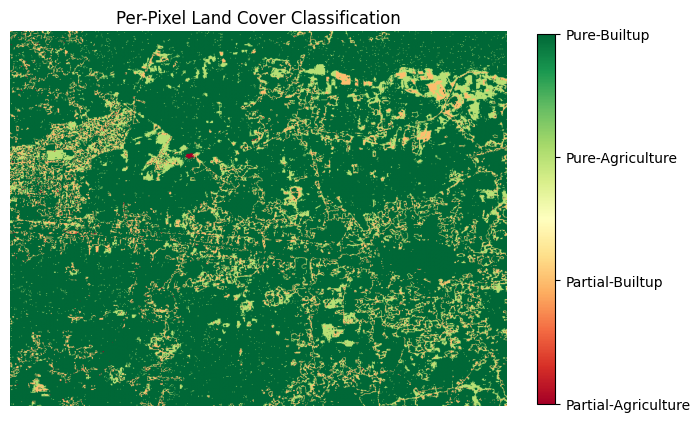

In [231]:
import matplotlib.pyplot as plt

vmin,vmax = 0,len(class_names)-1

# Map class codes back to names, if you saved them
if class_names is not None:
    cmap = plt.get_cmap('tab10', len(class_names))
else:
    cmap = 'viridis'

with rasterio.open('classified_image-V3.tif') as src:
    img = src.read(1)

plt.figure(figsize=(8,8))
im = plt.imshow(img, cmap='RdYlGn', vmin=vmin, vmax=vmax)
plt.axis('off')
cbar = plt.colorbar(im, ticks=np.arange(len(class_names)),shrink=0.6)
cbar.ax.set_yticklabels(class_names)
plt.title("Per-Pixel Land Cover Classification")
plt.show()


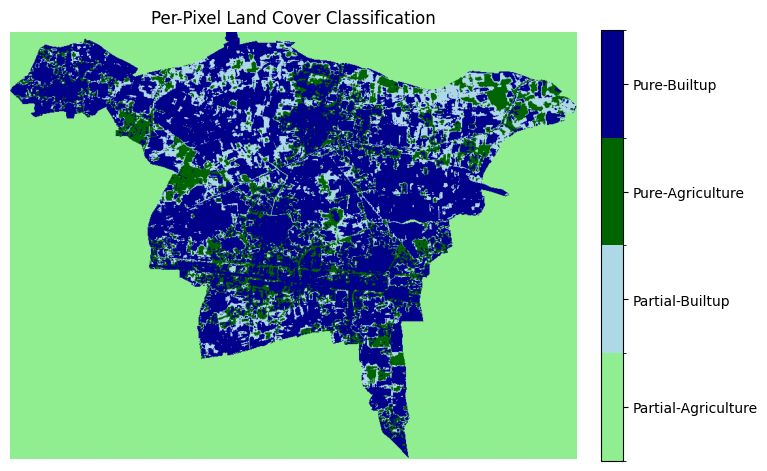

In [232]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import rasterio

# 1. Define your colors in the same order as class_names
color_list = [
   
    'lightgreen',        # Partial-Agri Done
    'lightblue',         # Partial Builtup Done
    'darkgreen'   ,      # Pure Agri done
    'darkblue',          # Pure Built-up Done
]
# 2. Create the colormap and norm
cmap = ListedColormap(color_list)
# Boundaries between classes: e.g. [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
bounds = np.arange(len(color_list)+1) - 0.5
norm   = BoundaryNorm(bounds, cmap.N)

# 3. Load your classified raster
with rasterio.open('classified_image-V2-clipped.tif') as src:
    img = src.read(1)

# 4. Plot with discrete colors
plt.figure(figsize=(8, 8))
im = plt.imshow(img, cmap=cmap, norm=norm)
plt.axis('off')

# 5. Add a legend‐style colorbar
cbar = plt.colorbar(
    im,
    ticks=np.arange(len(color_list)),
    boundaries=bounds,
    spacing='proportional',
    fraction=0.046, pad=0.04,
    shrink=0.7,
)
cbar.ax.set_yticklabels(class_names)
plt.title("Per-Pixel Land Cover Classification")
plt.show()


In [ ]:
# Writing multibankd RGB Image
import numpy as np
import rasterio

# your existing variables: classified (h×w), out_profile (dict)

class_colors = {
    1: (  0, 100,   0),   # Pure-Agriculture → dark green
    2: (144, 238, 144),   # Partial-Agriculture → light green
    3: (  0,   0, 139),   # Pure-Builtup → dark blue
    4: (173, 216, 230),   # Partial-Builtup → light blue
}

out_profile.update({
    "dtype": "uint8",
    "count": 3,
    "compress": "lzw",
    "photometric": "RGB",
    "interleave": "pixel",
})
# remove nodata so 0 => black, not white
out_profile.pop("nodata", None)

with rasterio.open("classified_rgb_fixed.tif", "w", **out_profile) as dst:
    dst.write(rgb)
print("Exported properly tagged RGB image: classified_rgb_fixed.tif")


Exported properly tagged RGB image: classified_rgb_fixed.tif
